### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

### Data Load

In [2]:
csv_file_path = '..\\data\\ball_by_ball_it20.csv'  
df = pd.read_csv(csv_file_path) 
df.head()


,Unnamed: 0,Match ID,Date,Venue,Bat First,Bat Second,Innings,Over,Ball,Batter,...,Winner,Chased Successfully,Total Batter Runs,Total Non Striker Runs,Batter Balls Faced,Non Striker Balls Faced,Player Out Runs,Player Out Balls Faced,Bowler Runs Conceded,Valid Ball
0,0,1339605,2023-03-26,SuperSport Park,West Indies,South Africa,1,1,1,BA King,...,South Africa,1,1,0,1,0,NaN,NaN,1,1
1,1,1339605,2023-03-26,SuperSport Park,West Indies,South Africa,1,1,2,KR Mayers,...,South Africa,1,1,1,1,1,NaN,NaN,1,1
2,2,1339605,2023-03-26,SuperSport Park,West Indies,South Africa,1,1,3,BA King,...,South Africa,1,0,1,0,1,1.0,2.0,0,1
3,3,1339605,2023-03-26,SuperSport Park,West Indies,South Africa,1,1,4,J Charles,...,South Africa,1,0,1,1,1,NaN,NaN,0,1
4,4,1339605,2023-03-26,SuperSport Park,West Indies,South Africa,1,1,5,J Charles,...,South Africa,1,4,1,2,1,NaN,NaN,4,1


### Data Preprocessing

In [3]:
# Drop incomplete records
df = df.dropna(subset=['Match ID', 'Bat First', 'Bat Second', 'Winner'])

# Group by Match to get Team1/2 scores and wickets
match_runs = df.groupby(['Match ID', 'Innings'])['Innings Runs'].max().unstack()
match_wickets = df.groupby(['Match ID', 'Innings'])['Innings Wickets'].max().unstack()

# Get match-level meta data
match_info = df.groupby('Match ID').agg({
    'Date': 'first',
    'Venue': 'first',
    'Bat First': 'first',
    'Bat Second': 'first',
    'Target Score': 'max',
    'Winner': 'first'
}).reset_index()

# Attach run/wicket stats
match_info['Team1_Runs'] = match_runs[1].values
match_info['Team2_Runs'] = match_runs[2].values
match_info['Team1_Wickets'] = match_wickets[1].values
match_info['Team2_Wickets'] = match_wickets[2].values


### Feature Enginnering

In [4]:
# Date and Time features
match_info['Date'] = pd.to_datetime(match_info['Date'], errors='coerce')
match_info['Year'] = match_info['Date'].dt.year

# Simulate match time
np.random.seed(42)
match_info['Time'] = np.random.choice(['Day', 'Night'], len(match_info))


# Simulate or merge weather
weather_options = ['Clear', 'Cloudy', 'Rainy', 'Humid']
match_info['Weather'] = np.random.choice(weather_options, len(match_info), p=[0.6, 0.2, 0.1, 0.1])


# Toss Winner and Label: Bat First team wins or not
match_info['Toss Winner'] = match_info['Bat First']
match_info['Bat_First_Won'] = (match_info['Winner'] == match_info['Bat First']).astype(int)


### Visualization

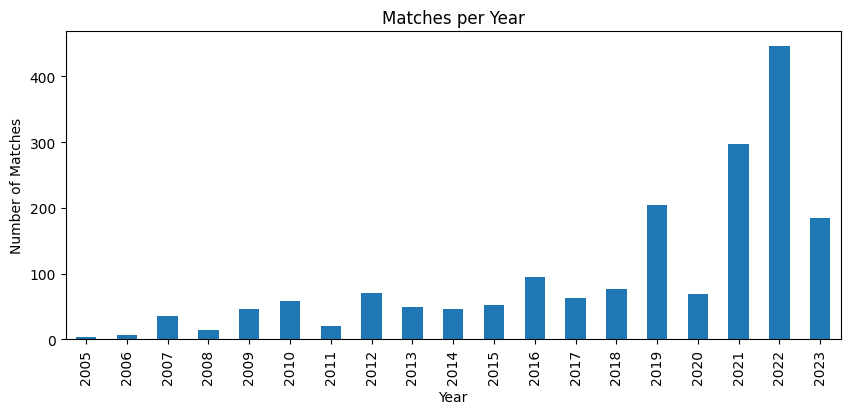

In [5]:
# Matches per Year
plt.figure(figsize=(10, 4))
match_info['Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Matches per Year")
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.show()


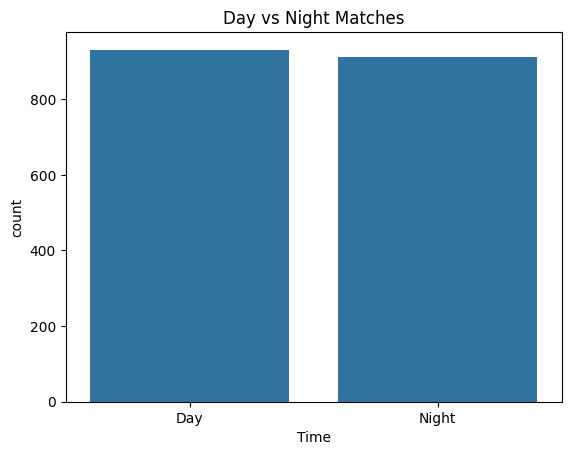

In [6]:
# Day vs Night Matches
sns.countplot(data=match_info, x='Time')
plt.title("Day vs Night Matches")
plt.show()


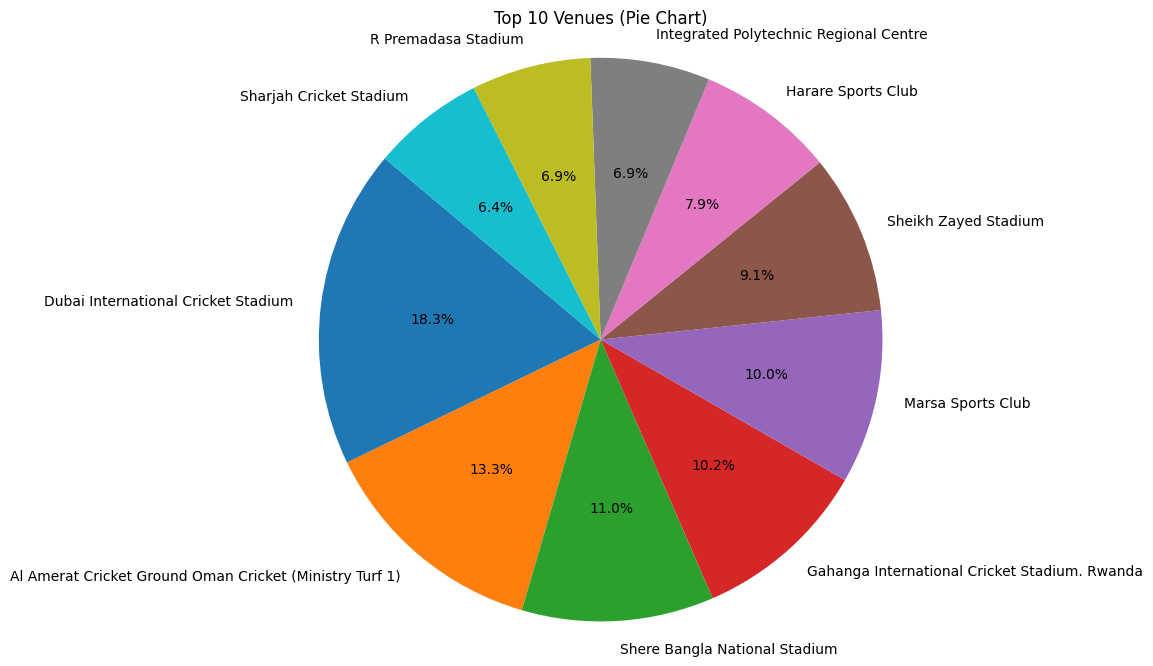

In [7]:
# Vanue distribution

plt.figure(figsize=(8, 8))
venue_counts = match_info['Venue'].value_counts().nlargest(10)
plt.pie(venue_counts.values, labels=venue_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Venues (Pie Chart)")
plt.axis('equal')
plt.show()

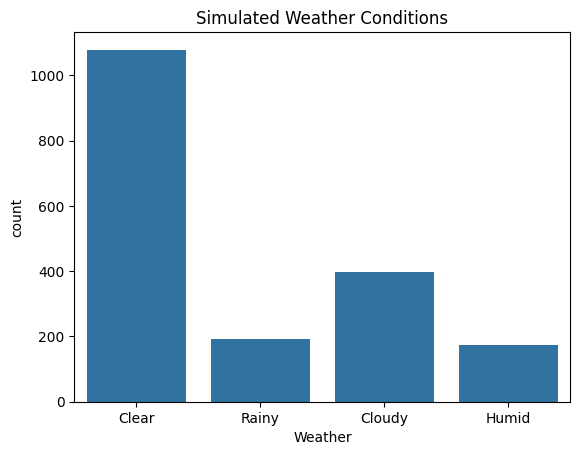

In [8]:
# Weather distribution
sns.countplot(x='Weather', data=match_info)
plt.title("Simulated Weather Conditions")
plt.show()


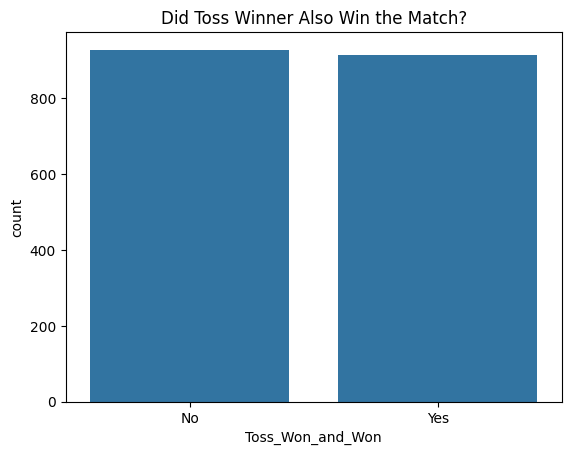

In [9]:
# Toss winner vs match winner
match_info['Toss_Won_and_Won'] = (match_info['Toss Winner'] == match_info['Winner']).astype(int)

sns.countplot(data=match_info, x='Toss_Won_and_Won')
plt.title("Did Toss Winner Also Win the Match?")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


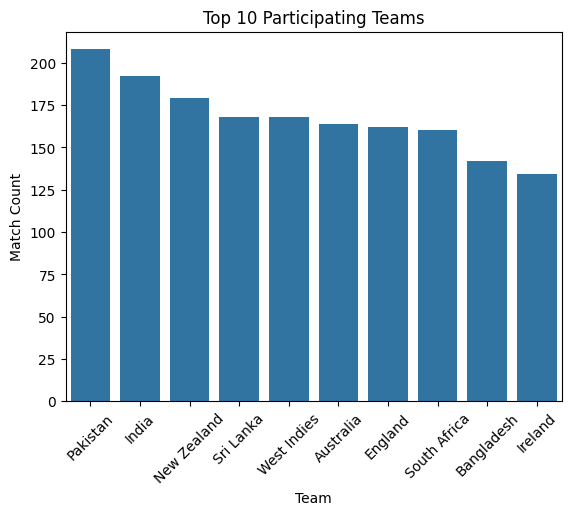

In [10]:
# Participating Teams
teams = pd.concat([match_info['Bat First'], match_info['Bat Second']])
top_teams = Counter(teams).most_common(10)
teams_df = pd.DataFrame(top_teams, columns=['Team', 'Match Count'])

sns.barplot(x='Team', y='Match Count', data=teams_df)
plt.title("Top 10 Participating Teams")
plt.xticks(rotation=45)
plt.show()


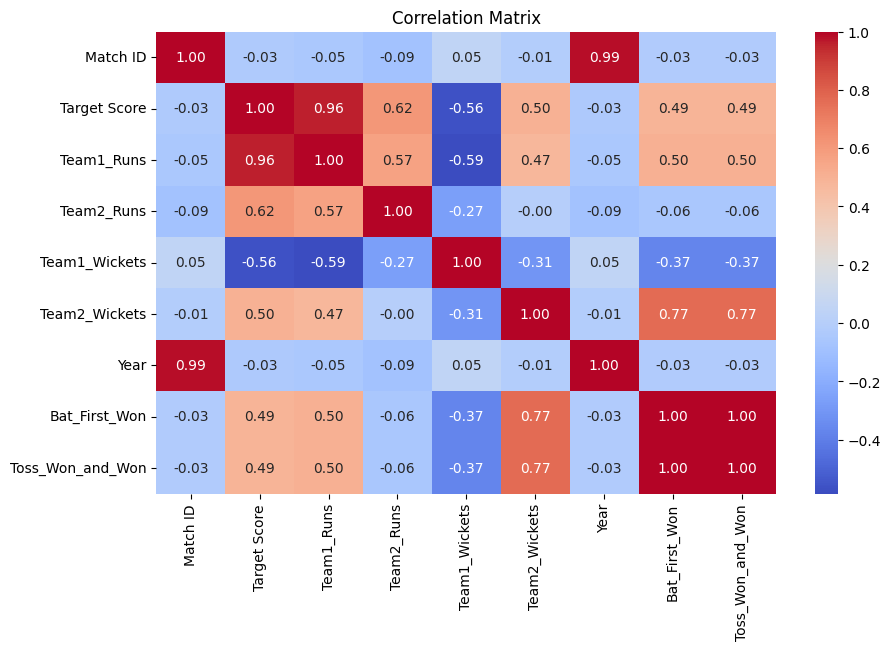

In [11]:
# Correlation Heatmap
numerics = match_info.select_dtypes(include='number')

plt.figure(figsize=(10, 6))
sns.heatmap(numerics.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


### Encode Features for Modeling

In [12]:
# Combine all teams and cast to string to avoid type mix
all_teams = pd.concat([
    match_info['Bat First'].astype(str),
    match_info['Bat Second'].astype(str),
    match_info['Toss Winner'].astype(str)
]).unique()

le_team = LabelEncoder()
le_team.fit(all_teams)
le_venue = LabelEncoder()
le_weather = LabelEncoder()

# Transform after casting to string
match_info['Bat First'] = le_team.transform(match_info['Bat First'].astype(str))
match_info['Bat Second'] = le_team.transform(match_info['Bat Second'].astype(str))
match_info['Toss Winner'] = le_team.transform(match_info['Toss Winner'].astype(str))
match_info['Venue'] = le_venue.fit_transform(match_info['Venue'])
match_info['Weather'] = le_weather.fit_transform(match_info['Weather'])
match_info['Time'] = match_info['Time'].map({'Day': 0, 'Night': 1})


### Feature Selection

In [13]:
features = [
    'Venue', 'Bat First', 'Bat Second', 'Toss Winner',
    'Team1_Runs', 'Team2_Runs', 'Team1_Wickets', 'Team2_Wickets',
    'Target Score', 'Weather', 'Time'
]

X = match_info[features]
y = match_info['Bat_First_Won']  


###  Dataa Split for Train/Test 
**considersing 80% for train data and 20% test data**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Model Train
**I am taking XGBoost as model**

In [15]:
model = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


e:\PyEnvironment\ds_env\lib\site-packages\xgboost\training.py:183: UserWarning: [19:36:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation

Accuracy: 0.9322493224932249
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       186
           1       0.97      0.89      0.93       183

    accuracy                           0.93       369
   macro avg       0.94      0.93      0.93       369
weighted avg       0.94      0.93      0.93       369



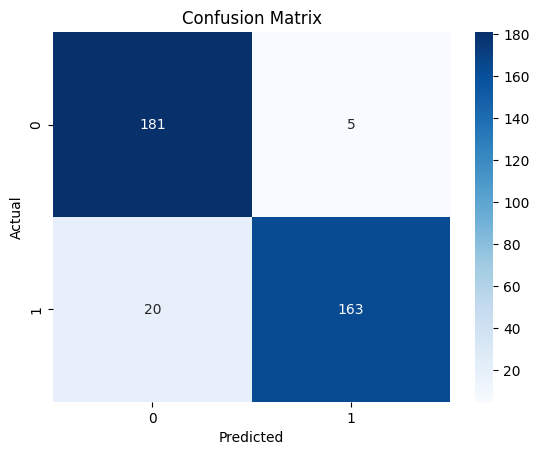

In [16]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Feature Importance Visualization

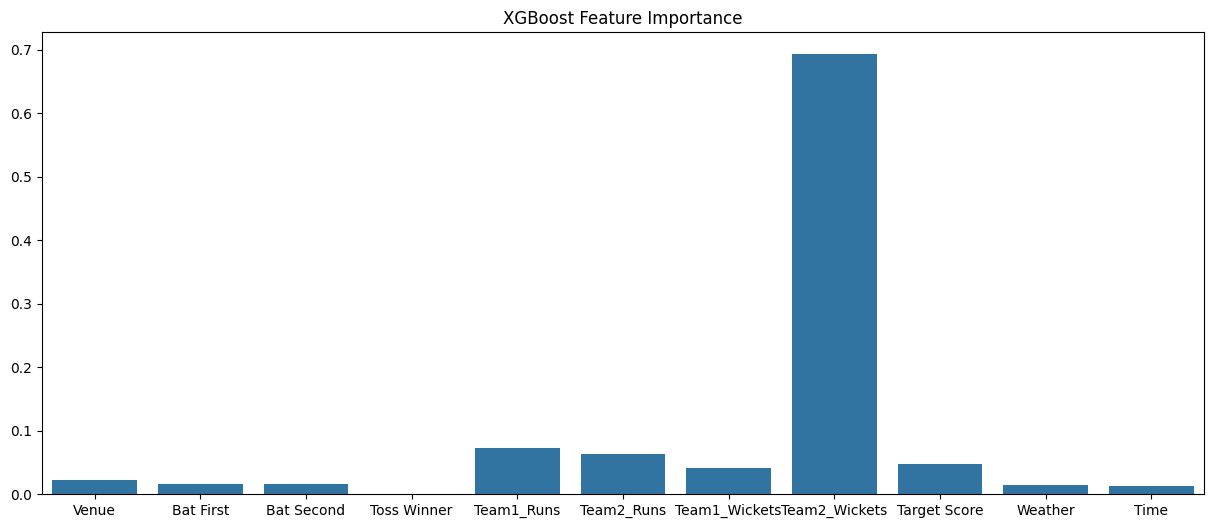

In [17]:
importances = model.feature_importances_
plt.figure(figsize=(15, 6))
sns.barplot(y=importances, x=features)
plt.title("XGBoost Feature Importance")
plt.show()


### Save the Model

In [18]:
joblib.dump(model, "model/xgb_match_predictor.joblib")
print("Model saved to model/xgb_match_predictor.joblib")


Model saved to model/xgb_match_predictor.joblib


###  Load the saved model

In [19]:
# Load model
loaded_model = joblib.load("model/xgb_match_predictor.joblib")

### Random Sample to Predict

In [20]:
# Predict on few random test rows
sample = X_test.sample(n=5, random_state=None)
preds = loaded_model.predict(sample)

# For each sample, print decoded (human-readable) values
for i in range(len(sample)):
    row = sample.iloc[i]
    print(f"\n🎯 Sample {i+1}")
    print("-" * 40)

    # Decode encoded values
    venue_name = le_venue.inverse_transform([int(row['Venue'])])[0]
    bat_first_team = le_team.inverse_transform([int(row['Bat First'])])[0]
    bat_second_team = le_team.inverse_transform([int(row['Bat Second'])])[0]
    toss_winner_team = le_team.inverse_transform([int(row['Toss Winner'])])[0]
    weather = le_weather.inverse_transform([int(row['Weather'])])[0]
    time = 'Day' if row['Time'] == 0 else 'Night'

    # Print readable input
    print(f"Venue         : {venue_name}")
    print(f"Bat First     : {bat_first_team}")
    print(f"Bat Second    : {bat_second_team}")
    print(f"Toss Winner   : {toss_winner_team}")
    print(f"Weather       : {weather}")
    print(f"Time          : {time}")
    print(f"Team1 Runs    : {row['Team1_Runs']}")
    print(f"Team2 Runs    : {row['Team2_Runs']}")
    print(f"Team1 Wickets : {row['Team1_Wickets']}")
    print(f"Team2 Wickets : {row['Team2_Wickets']}")
    print(f"Target Score  : {row['Target Score']}")


    result = "Bat-first team WON ✅" if preds[i] == 1 else "Bat-first team LOST ❌"
    print(f"🔮 Prediction    : {result}")



🎯 Sample 1
----------------------------------------
Venue         : Feroz Shah Kotla
Bat First     : England
Bat Second    : Sri Lanka
Toss Winner   : England
Weather       : Clear
Time          : Night
Team1 Runs    : 171
Team2 Runs    : 161
Team1 Wickets : 4
Team2 Wickets : 8
Target Score  : 172
🔮 Prediction    : Bat-first team WON ✅

🎯 Sample 2
----------------------------------------
Venue         : Independence Park
Bat First     : Cook Islands
Bat Second    : Fiji
Toss Winner   : Cook Islands
Weather       : Clear
Time          : Night
Team1 Runs    : 142
Team2 Runs    : 143
Team1 Wickets : 10
Team2 Wickets : 7
Target Score  : 143
🔮 Prediction    : Bat-first team LOST ❌

🎯 Sample 3
----------------------------------------
Venue         : Sharjah Cricket Stadium
Bat First     : Afghanistan
Bat Second    : Scotland
Toss Winner   : Afghanistan
Weather       : Clear
Time          : Day
Team1 Runs    : 132
Team2 Runs    : 105
Team1 Wickets : 7
Team2 Wickets : 6
Target Score  : 133
🔮 